## Clasification Models
### using MNIST dataset - Number recognition

In [28]:
from sklearn.datasets import load_digits
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

In [20]:
def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]

In [23]:
try:
    from sklearn.datasets import fetch_openml
    mnist = fetch_openml('mnist_784', version=1, cache=True, as_frame=False)
    mnist.target = mnist.target.astype(np.int8) # fetch_openml() returns targets as strings
    sort_by_target(mnist) # fetch_openml() returns an unsorted dataset
except ImportError:
    from sklearn.datasets import fetch_mldata
    mnist = fetch_mldata('MNIST original')
mnist["data"], mnist["target"]

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([0, 0, 0, ..., 9, 9, 9], dtype=int8))

In [24]:
X =  mnist["data"]
y = mnist["target"]

In [26]:
X.shape

(70000, 784)

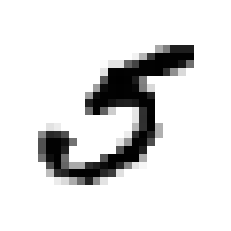

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt

some_digit = X[36000]   # feature vector of ocurrence 36000
some_digit_image = some_digit.reshape(28, 28) #reshape it to a 28x28 array
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary, # Plot
interpolation="nearest")
plt.axis("off")
plt.show()

In [30]:
# the set is already split into train and test: 
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [31]:
# Shuffle the training set, as some algorithms are sensitive to find many same obs in a row:
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

### Binary Classifier
#### We want to identify one number vs all others. 

In [32]:
# Target vectors:
y_train_2 = (y_train == 2) # True for all 2
y_test_2 = (y_test == 2) # True for all 2

In [34]:
# Stochastic Gradient Descent: this classifier handle big datasets efficiently as the training instances
# are independent , and used one at a time

from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42) # relies on randomness during training - thats why we need the random state
sgd_clf.fit(X_train, y_train_2)

SGDClassifier(random_state=42)

In [36]:
sgd_clf.predict([some_digit]) # We already know this one is a 5 and not a 2

array([False])

####  Model Accuracy using Cross Validation:
Cross validation is a resampling process where the sample data is split in k folds ( that is why is often called 'Kfold cross validation') What we want to do is test the model in unseen data . That is, to use a limited sample in order to estimate how the model is expected to perform in general when used to make predictions on data not used during the training of the model. We need the model to be generalizable.  
Each fold, should contain a representative ratio of each class. 

In [38]:
# One option is to use cross_val_score() or to implement it by hand - lets see both

from sklearn.model_selection import StratifiedKFold # method that performs the stratified sampling
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3)
for train_index, test_index in skfolds.split(X_train, y_train_2):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_2[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_2[test_index])
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred)) 


0.97295
0.97085
0.9757


In [40]:
#Other option is to use cross_val_score() again with 3 folds
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_2, cv=3, scoring="accuracy") 


# Accuracy score is same as the jaccard score as this is binary classification.
# Returns counts the number of corrected classified samples
# As we can see is the same result as manually
# for the 3 folds, we can successfully identify the 2 in the dataset roughly 97% of the time

array([0.97295, 0.97085, 0.9757 ])

In [49]:
# Lets also evaluate the non 2s accuracy:
from sklearn.base import BaseEstimator
class Never2Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    
never_2_clf = Never2Classifier()
cross_val_score(never_2_clf, X_train, y_train_2, cv=3, scoring="accuracy")
# since only 10% of the images are 2, we always have the 90% chance of guessing it right
# Maybe 'Accuracy' is not the best classsifier in this case, when some classes are more frequent than others 
# like in this case, there much more non 2 than 2 

array([0.89975, 0.9036 , 0.89875])

####  Model Accuracy using Monte Carlo Cross-Validation:

Also known as repeated random subsampling CV: the datasets get randomly partitioned into training and validation sets.
Steps:
1. Split training data randomly (maybe 70–30% split or 62.5–37.5% split or 86.3–13.7%split). For each iteration, the train-test split percentage is different. If the % do not sum 100, the remaining observations will not be used. 
Fit the model on train data set for that iteration and calculate test error using the fitted model on test data
2. Repeat many iterations (say 100 or 500 or even 1000 iterations) and take the average of the test errors.
Note - the same data can be selected more than once in the test set or even never at all.

This procedure is not great for non balanced datasets, meaning that it works better when we have the same amout of observations of each class. In Mnist example, we have equal observations of each number so we are fine

In [45]:
# We only have to define ShuffleSplit and replace it cv
from sklearn.model_selection import ShuffleSplit
cv = ShuffleSplit(n_splits=3, test_size=0.3, random_state=0)
scores = cross_val_score(sgd_clf, X_train, y_train_2,cv=cv)

print("cross Validation scores:n {}".format(scores))
print("Average Cross Validation score :{}".format(scores.mean()))

cross Validation scores:n [0.97344444 0.97227778 0.96361111]
Average Cross Validation score :0.9697777777777778


With Monte carlo cross validation the score is a little lower than with kfold CV but still in the same range . 
We could increase the number of splits and look at the average: 

In [46]:
cv = ShuffleSplit(n_splits=20, test_size=0.3, random_state=0)
scores = cross_val_score(sgd_clf, X_train, y_train_2,cv=cv)

print("Average Cross Validation score :{}".format(scores.mean()))

Average Cross Validation score :0.9648694444444447


### Confusion Matrix
Another way to evaluate the clasification performance. Here we count the number of times instances of class A are classified as class B. 
What we need :
1. Set of predictors
2. Actual targets
3. Using cross_val_predict() function that performs a kfold CV but instead of giving scores, returns predictions made for each fold
First we will run this using only test set , and at the very end we could do it with the test set

In [50]:
from sklearn.model_selection import cross_val_predict
# here we get the predictions
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_2, cv=3)

In [61]:
from sklearn.metrics import confusion_matrix
#confusion_matrix(y_train_2, y_train_pred)
confusion_matrix(y_train_2, y_train_pred)

array([[53308,   734],
       [  876,  5082]])

#### Precision and Recall

In [75]:
# Precision : Accuracy of the positive predictions - Can also be called specificity
# TP/(TP+FP)
tp = confusion_matrix_df.iloc[1][1]
fp = confusion_matrix_df.iloc[0][1]
print('Precision is :'+ str(tp/(tp+fp)))

# Recall or Sensitivity or TPR True positive rate:
# Ratio of positive instances correctly detected by the clasifier
# TP/TP+FN
fn = confusion_matrix_df.iloc[1][0]
print('TPR is :'+ str(tp/(tp+fn)))


Precision is :0.8737964236588721
TPR is :0.8529707955689829


In [78]:
# We can also calculate precision and Recall using scikit learn:
from sklearn.metrics import precision_score, recall_score
print(precision_score(y_train_2, y_train_pred))
print(recall_score(y_train_2, y_train_pred))


0.8737964236588721
0.8529707955689829


Recall means :I am able to identify Actual positives 85% of the time.

Precision means: When I predict a 2,I am right 87% of the time.

Depending on the problem you might be willing to sacrifice precission in pos of recall. For example in disease diagnosis, I would like to have the least false negatives possible. Meaning , I am not able to ideantify the disease and the patient do not get treatment. In that case, I want the recall to be the highest. But maybe I dont care that much about the precision. I rather 'over diagnose' that leave people untreated. 

In [83]:
# Combined metric F1: HARMONIC MEAN: giving more weight to low values
# F1 is low only if BOTH recall and precision are high
# it will depend on the problem, if you either want more precsion or more recall
# TP /(TP+((FN+FP)/2))
F1 = tp /(tp+((fn+fp)/2))
print(F1)

0.8632580261593341


In [82]:
# Or using scikit learn:
from sklearn.metrics import f1_score
f1_score(y_train_2, y_train_pred)

0.8632580261593341

#### Precision and Recall tradeoff
to exemplify we will use the method decision_function(), this will retrieve the score for each instance
so we can define the threshold neede for the decision and evaluate the trade off

In [89]:
y_scores = sgd_clf.decision_function([some_digit]) #remember 'some_digit' is a 5
y_scores
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [90]:
#higher threshold
threshold = 200000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [92]:
# lets get all the scores for all instances:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_2, cv=3,method="decision_function")
# Calculating precision and recall:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_2, y_scores)

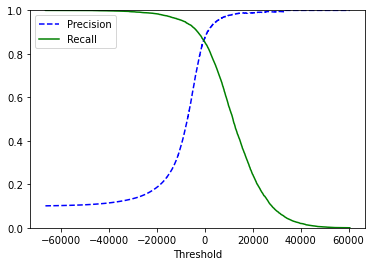

In [94]:
#plot the trade off
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()


As the threshold is higher, precision increase but recall decrease. with a higher th we are more likely to find more true positives, but also false negatives. 
Which is the best threshold ? 

### ROC curve (receiver operating characteristic)

Plot True positive rate (Recall or sensitivity) vs False positive rate (1-true negative rate or 1-specificity)

First  we need to compute TPR and FPR for many th's ..

We can use roc_curve()


In [97]:
from sklearn.metrics import roc_curve,roc_auc_score
fpr, tpr, thresholds = roc_curve(y_train_2, y_scores)

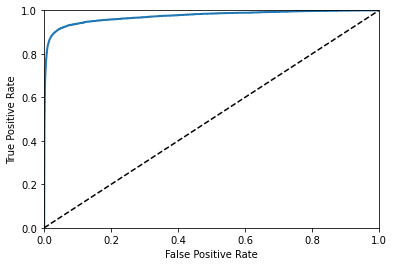

In [96]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
plot_roc_curve(fpr, tpr)
plt.show()

The higher the Recall or TPR the more false possitives (FPR) we will have too. 
the dotted line is a random classifier, we want to stay the furthest away from it possible. 
Area under the curve or AUC : if AUC=1 then we have the perfect classifier, where we only predict positives when they are and the FP are zero. If AUC = 0 then our model performs the same as a random classifier. 

In [98]:
AUC = roc_auc_score(y_train_2, y_scores)
AUC

0.9732413188161099

Rule of Thumb for which method to use: PR curve is  better when the positive class is rare and you care more about the false positives than the false negatives. ROC curve works better otherwise. That is why also why the context and the final goal of the analysis is so important.  

### Multiclass Classifier or Multinomial classifier : 
Can distingish between more than 2 classes. 
We could use Random Forest Classifier, or naive Bayes

'One-versus-all' : we could also run multiple binary classifiers, you get the score for each classifier and each instance, and chose the one with the higher score. It would be the one with highest chances to be True positive. We run few classifiers in the big dataset. This is the default used in scikit learn. 

'One-versus-One': train a binary classifier for pairs of digits( in the mnist example). If there are N classes, you would need N(N-1)/2 clasifiers. in Mnist we need 45 classifiers running in small training sets.  SVM we preffer OvO

In [100]:
# its just a matter of using the entire datasets and it will do a one versus all
# Under the hood, Scikit-Learn actually trained 10 binary classifiers, got their decision scores for the
# image, and selected the class with the highest score
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

SGDClassifier(random_state=42)

In [101]:
some_digit_scores = sgd_clf.decision_function([some_digit]) # returns 10 scores one for each binary classificator
# the highers should be the one for 5 as that is the number
print(some_digit_scores)
print(np.argmax(some_digit_scores))

[[ -7256.26167808 -51172.39069351  -9749.84884904  -3434.51166514
  -12492.76731225   3553.57847675 -32048.03406993 -24181.42810204
  -13516.21895961 -11197.77478857]]
5


In [103]:
# If we want to force it to use OvO:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
print(ovo_clf.predict([some_digit])) # the classification
print(len(ovo_clf.estimators_)) #How many estimators?


[5]
45


### Random Forest Classifier : no need for OvO or OvA as the random forest is multinomial classificiation:

Random Forest classification consists of a large number of decision trees that operates as an ensemble. Each individual tree in the random forest splits out a class prediction and the class with the most votes becomes our model’s prediction. 

The low correlation between models is the key. Uncorrelated models can produce ensemble predictions that are more accurate than any of the individual predictions. The reason for this is that the trees protect each other from their individual errors (as long as they don’t constantly all err in the same direction). While some trees may be wrong, many other trees will be right, so as a group the trees are able to move in the correct direction.

In [106]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_2, cv=3,method="predict_proba")

forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])
print(forest_clf.predict_proba([some_digit])) # Shows the prediction , In which one is more confident, and which ones 
# look similar although not the same  - in this case, the model predicts 85% chance is a 5, bt it could be a zero 6% chance

[[0.06 0.   0.   0.04 0.   0.85 0.   0.02 0.02 0.01]]


In [108]:
# Finally as usual we want to evaluate how good is our classification:
print(cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy"))

[0.87665 0.8768  0.8781 ]


### ERROR ANALYSIS 
Maybe we found a promissing model and we want to improve it

In [109]:
# lets scale the data first, just because it will give better results - ALWAYS SCALE!
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
# getting the confusion matrix
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

In [114]:
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5579,    0,   22,    6,    8,   49,   29,    5,  224,    1],
       [   0, 6427,   44,   22,    3,   42,    5,    8,  182,    9],
       [  27,   29, 5248,   87,   69,   22,   70,   41,  353,   12],
       [  24,   21,  126, 5240,    0,  204,   26,   42,  384,   64],
       [  10,   13,   43,   11, 5238,    8,   33,   25,  309,  152],
       [  27,   18,   32,  149,   49, 4497,   77,   18,  487,   67],
       [  27,   19,   49,    3,   41,   94, 5532,    7,  146,    0],
       [  20,   12,   54,   22,   51,   10,    5, 5723,  173,  195],
       [  15,   64,   40,   90,    2,  124,   26,    7, 5441,   42],
       [  26,   21,   28,   61,  122,   34,    1,  172,  327, 5157]])

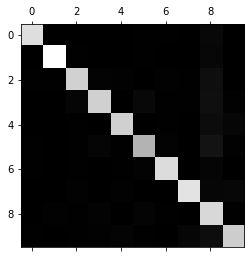

In [112]:
# Visualizing it better:
plt.matshow(confusion_matrix(y_train, y_train_pred), cmap=plt.cm.gray)
plt.show()

The greys in the diagonal show that the algorithms predict pretty well, maybe having some trouble detecting fives. 

[[5923]
 [6742]
 [5958]
 [6131]
 [5842]
 [5421]
 [5918]
 [6265]
 [5851]
 [5949]]


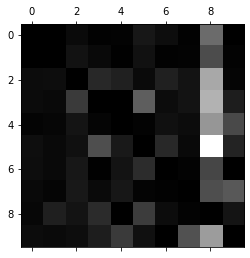

[[0.         0.         0.00371433 0.001013   0.00135067 0.00827283
  0.00489617 0.00084417 0.03781867 0.00016883]
 [0.         0.         0.00652625 0.00326313 0.00044497 0.00622961
  0.00074162 0.00118659 0.02699496 0.00133492]
 [0.00453172 0.00486741 0.         0.01460222 0.01158107 0.00369251
  0.01174891 0.0068815  0.05924807 0.0020141 ]
 [0.00391453 0.00342522 0.0205513  0.         0.         0.03327353
  0.00424074 0.00685043 0.06263252 0.01043875]
 [0.00171174 0.00222527 0.00736049 0.00188292 0.         0.00136939
  0.00564875 0.00427936 0.05289284 0.02601849]
 [0.00498063 0.00332042 0.00590297 0.0274857  0.00903892 0.
  0.01420402 0.00332042 0.08983582 0.01235934]
 [0.00456235 0.00321054 0.00827982 0.00050693 0.00692802 0.01588374
  0.         0.00118283 0.0246705  0.        ]
 [0.00319234 0.0019154  0.00861931 0.00351157 0.00814046 0.00159617
  0.00079808 0.         0.02761373 0.0311253 ]
 [0.00256366 0.0109383  0.00683644 0.01538199 0.00034182 0.02119296
  0.00444368 0.00119

In [118]:
# divide each value in the confusion matrix by the number of images in the corresponding class, 
# so as to compare error rates instead of absolute number of errors
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

print(row_sums) # the total number of obs of each class 


# then lets just put 0 in te diagonal so as to focus on errors:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
# Rows are the actuals, and columns are the predicted
plt.show()
print(norm_conf_mx) # filled with 0 in the diagonal

Column wise : Mostly numbers 8 and 9 are predicted erroneously. We think they are 8 or 9 but they are not
while 1 and 2 , are pretty dark which means its mostly correct with we predict 1 or 2

Row wise: 8 and 9 are also brighter than the rest, meaning that we also have trouble identifying correctly 8 and 9. 

It could be useful to get more data for 8 and 9 so they are classified better

## Multilabel Classification : multiple classes for one instance

Example with KNeighborsClassifier : The KNN algorithm assumes that similar things exist in close proximity. In other words, similar things are near to each other. 
Steps of the algorithm:The KNN Algorithm
1. Load the data
2. Initialize K to your chosen number of neighbors
3. For each example in the data

   3.1 Calculate the distance between the query example and the current example from the data.
   
   3.2 Add the distance and the index of the example to an ordered collection
4. Sort the ordered collection of distances and indices from smallest to largest (in ascending order) by the distances
5. Pick the first K entries from the sorted collection
6. Get the labels of the selected K entries
7. If regression, return the mean of the K labels
8. If classification, return the mode of the K labels

In [120]:
from sklearn.neighbors import KNeighborsClassifier

# Create a y_multilabel that has 2 targets : large number and odd number

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [122]:
# Lets make a prediction:
knn_clf.predict([some_digit]) # the number is small and odd

array([[False,  True]])

In [123]:
# Evaluate the algorithm using the F1 just as before:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_train, cv=3)
f1_score(y_train, y_train_knn_pred, average="macro")
# 'macro' : so all labels are equally important
# 'weighted' : for example if you have different number of instances for each class

0.9676151757431735